In [2]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

random.seed(42)

## Haar Cascades

Based on the popular [Viola-Jones](https://link.springer.com/article/10.1023/B:VISI.0000013087.49260.fb) framework for object detection. They proposed using Haar filters (two-valued,  rectangular masks), efficiently computed using "integral" images (where each pixel value is replaced with the sum of all the pixel values above and to the left of it). Something like a 2D, discrete CDF in probability theory. They also proposed using a "cascade" of weak classifiers to improve performance.

OpenCV offers an implementation of this under the "CascadeClassifier" class, along with pretrained classifiers for face detection. 

In [84]:
def detect_faces_haar(image_path, output_path): 
    # Path to preset face detection cascade file that come with OpenCV out of the box. Some other cascade files can be found at venv/Lib/site-packages/cv2/data
    face_detection_cascade_file = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    face_cascade = cv2.CascadeClassifier(face_detection_cascade_file)     

    image = cv2.imread(image_path)
    cv2.imshow("Base image", image)
    faces_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Parameters for detectMultiScale taken from https://stackoverflow.com/questions/20801015/recommended-values-for-opencv-detectmultiscale-parameters 
    # along with some experiments on the sample image
    faces = face_cascade.detectMultiScale(faces_gray, scaleFactor = 1.2, minNeighbors = 4)      # these values can be changed as needed 

    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    cv2.imwrite(output_path, image)
    cv2.imshow("Detected faces (Haar Cascade)", image)
    print("Close windows or press key to exit.")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [91]:
def detect_face_from_camera():

    face_detection_cascade_file = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    face_cascade = cv2.CascadeClassifier(face_detection_cascade_file) 

    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not access the webcam.")
        return "Error"

    print("Press 'q' to capture an image and 'e' to exit.")
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Failed to grab frame.")
                break

            cv2.imshow("Camera Feed", frame)
            key = cv2.waitKey(1)
            if key == ord("q"):
                gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray_img, scaleFactor = 1.2, minNeighbors = 4)      # these values can be changed as needed

                result = "Non-face"
                color = (0, 0, 255) 

                if len(faces) > 0:
                    result = "Face"
                    color = (0, 255, 0)
                    
                    for (x, y, w, h) in faces:
                        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

                cv2.putText(
                    frame,
                    result,
                    (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    color,
                    2,
                    cv2.LINE_AA,
                )
                cv2.imshow("Captured Image", frame)

            if key == ord("e"):
                break
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        cap.release()
        cv2.destroyAllWindows()

In [92]:
detect_faces_haar("samples/face_detection/solvay_color.jpg", "samples/face_detection/solvay_detected_haar.jpg")

Close windows or press key to exit.


In [93]:
detect_face_from_camera()

Press 'q' to capture an image and 'e' to exit.


Works well on the sample image, but the camera feed performance is terrible.

## HOG + SVM

In [11]:
# Should experiment with these 
ORIENTATIONS = 8
PIXELS_PER_CELL = (4,4)
CELLS_PER_BLOCK = (2,2)
IMAGE_SHAPE = (128,128)     # not 64x128 as in the paper because that was for people detection. We can use square windows for our use case.

In [12]:
FACE_FOLDER = os.path.join("data", "face", "Face")
NON_FACE_FOLDER = os.path.join("data", "other", "Other")
MAX_IMAGES = 2000

Testing

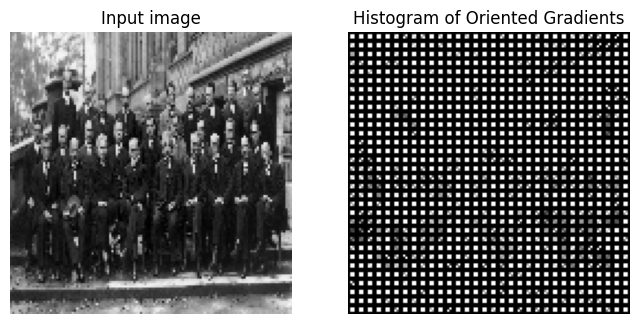

In [13]:
from skimage.feature import hog

# These 3 are needed if we didnt use cv2
from PIL import Image
from numpy import asarray
from skimage import data, exposure, color

# image = asarray(Image.open("samples/face_detection/solvay_color.jpg"))

image = cv2.imread("samples/face_detection/solvay_color.jpg", cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, IMAGE_SHAPE)  # Resize to 64x128

fd, hog_image = hog(
    image,
    orientations=ORIENTATIONS,
    pixels_per_cell=PIXELS_PER_CELL,
    cells_per_block=CELLS_PER_BLOCK,
    visualize=True,
    feature_vector=True
    # channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [14]:
def extract_hog_features(image,
                         orientations=ORIENTATIONS,
                         pixels_per_cell=PIXELS_PER_CELL,
                         cells_per_block=CELLS_PER_BLOCK,
                         visualize=False):
    """
    Compute HOG features for a given grayscale image.
    The image should be resized to the fixed detection window size.
    """

    image = cv2.resize(image, IMAGE_SHAPE)

    if visualize: 
        features, hog_image = hog(image,
                    orientations=orientations,
                    pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block,
                    block_norm='L2-Hys',
                    transform_sqrt=True,
                    feature_vector=True,
                    visualize=True)
        return features, hog_image
    
    else:
        features = hog(image,
                    orientations=orientations,
                    pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block,
                    block_norm='L2-Hys',
                    transform_sqrt=True,
                    feature_vector=True)

    return features

In [15]:
def get_feature_vectors_from_folder(folder, label, **kwargs):

    """
        Adapted from Ghaith's function in baseline.ipynb 

        kwargs could contain these keys: 
            - 'max_images': int value, limiting num images to add to the dataset
            - HOG hyperparameters: 'orientations' (int), 'pixels_per_cell', 'cells_per_block' and 'img_size'
    
        Returns a tuple containing 2 elements: 
            i)  a list of feature vectors (each feature vector is a list)
            ii) a list containing the passed in label repeated max_images times 
                i.e. a list of all 1's if we choose positive examples folder (i.e. data/face/Face folder) or all 0's for negative examples  
    """
    images_paths = [f for f in os.listdir(folder)]
    random.shuffle(images_paths)

    # Get kwargs, should just default to constants defined earlier
    max_images      = kwargs.get('max_images', None)
    orientations    = kwargs.get('orientations', ORIENTATIONS)
    pixels_per_cell = kwargs.get('pixels_per_cell', PIXELS_PER_CELL)
    cells_per_block = kwargs.get('cells_per_block', CELLS_PER_BLOCK)
    img_size        = kwargs.get('img_size', IMAGE_SHAPE)

    if max_images is not None:
        images_paths = images_paths[:max_images]

    features = []
    paths = []
    for image_path in images_paths:
        full_image_path = os.path.join(folder, image_path)
        img = cv2.imread(full_image_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            feature_vec = extract_hog_features(img,
                                            orientations=orientations,
                                            pixels_per_cell=pixels_per_cell,
                                            cells_per_block=cells_per_block)
            features.append(feature_vec)
            paths.append(full_image_path)

    return np.array(features), np.full(len(features), label), paths

In [16]:
face_vectors, face_labels, face_paths = get_feature_vectors_from_folder(
    FACE_FOLDER, label=1, max_images=MAX_IMAGES
)

non_face_vectors, non_face_labels, non_face_paths = get_feature_vectors_from_folder(
    NON_FACE_FOLDER, label=0, max_images=len(face_vectors)
)

Took around 40 seconds on my machine for 2000 face and 2000 non-face images (around 100 images/sec)

In [59]:
from sklearn.model_selection import train_test_split

X = np.vstack((face_vectors, non_face_vectors))   
y = np.hstack((face_labels, non_face_labels))
paths = face_paths + non_face_paths

# Manually shuffling so we can keep track of the list of image_paths as well
shuffled_indices = np.random.permutation(len(X))

X = X[shuffled_indices]
y = y[shuffled_indices]
shuffled_paths = [paths[ind] for ind in shuffled_indices]

split_index = int(len(X) * 0.8)
X_train = X[:split_index]
X_test  = X[split_index:]
y_train = y[:split_index]
y_test  = y[split_index:]
shuffled_paths_train = shuffled_paths[:split_index]
shuffled_paths_test = shuffled_paths[split_index:]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, shuffle=False
# )

In [60]:
# 8100 dimensional feature vectors
print("Training samples:", X_train.shape, y_train.shape)

Training samples: (3200, 8100) (3200,)


In [62]:
print(len(shuffled_paths_train))

3200


In [63]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", random_state=42)
svm.fit(X_train, y_train)

SVC(random_state=42)

In [64]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_hat = svm.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_hat)}")
print("Classification Report:\n", classification_report(y_test, y_hat))

Accuracy: 0.99375
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       383
           1       1.00      0.99      0.99       417

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



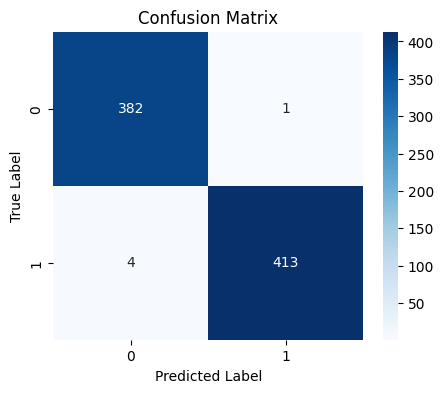

In [65]:
import seaborn as sns

cm = confusion_matrix(y_test, y_hat)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test),
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

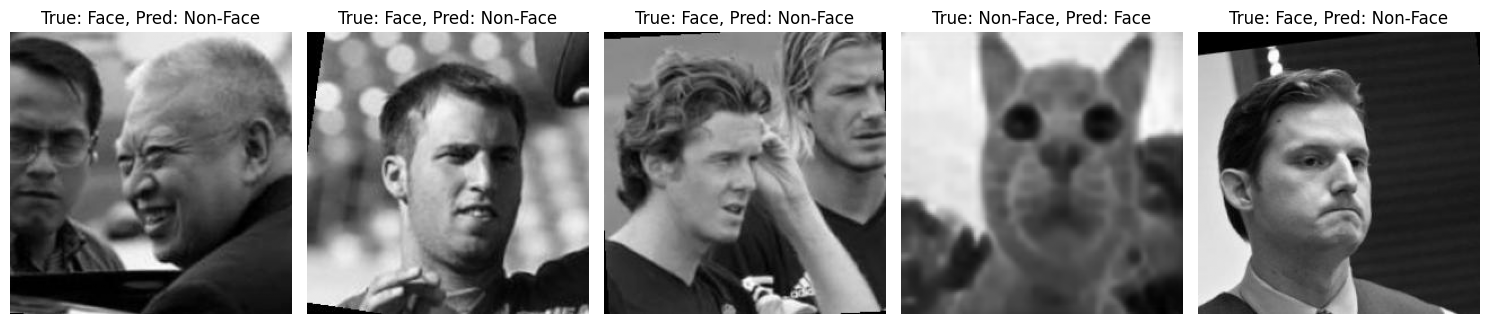

In [67]:
incorrect_indices = [i for i in range(len(y_test)) if y_hat[i] != y_test[i]]

random.seed(None)
random.shuffle(incorrect_indices)
random.seed(42)

num_to_display = min(len(incorrect_indices), 5)
plt.figure(figsize=(15, num_to_display))

for i in range(num_to_display):
    idx = incorrect_indices[i]

    true_label = "Face" if y_test[idx] == 1 else "Non-Face"
    predicted_label = "Face" if y_hat[idx] == 1 else "Non-Face"
    img = cv2.imread(shuffled_paths_test[idx], cv2.IMREAD_GRAYSCALE)

    plt.subplot(1, num_to_display, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {true_label}, Pred: {predicted_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [82]:
def classify_image_from_camera():
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not access the webcam.")
        return "Error"

    print("Press 'q' to capture an image and 'e' to exit.")
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Failed to grab frame.")
                break

            cv2.imshow("Camera Feed", frame)
            key = cv2.waitKey(1)
            if key == ord("q"):
                gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                gray_img = cv2.resize(gray_img, IMAGE_SHAPE)

                feature_vec = extract_hog_features(gray_img,
                                                orientations=ORIENTATIONS,
                                                pixels_per_cell=PIXELS_PER_CELL,
                                                cells_per_block=CELLS_PER_BLOCK)

                prediction = svm.predict(feature_vec.reshape(1,-1))
                result = "Face" if prediction == 1 else "Non-Face"
                color = (0, 255, 0) if prediction == 1 else (0, 0, 255)

                cv2.putText(
                    frame,
                    result,
                    (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    color,
                    2,
                    cv2.LINE_AA,
                )

                cv2.imshow("Captured Image", gray_img)
                cv2.imshow("Prediction", frame)

            if key == ord("e"):
                break
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        cap.release()
        cv2.destroyAllWindows()

In [83]:
classify_image_from_camera()

Press 'q' to capture an image and 'e' to exit.


TERRIBLE camera performance